# Gaussianity Check

Evaluate qualitatively and quantitatively whether the distribution of the output of the neural network is Gaussian.

- qualitative evaluation (Fig. 2)
    - Plot a histogram of the outputs to see if they approach Gaussian
- quantitative evaluation (Fig. 3)
    - Check the maximum mean discrepancy (MMD) between the distribution of the outputs and the Gaussian distribution to see if it approaches Gaussian
    
In particular, since theory suggests that the layer width of the last intermediate layer is important, compare the behavior of the large last intermediate layer with that of the other intermediate layers.

In [1]:
import torch
from torch import nn
import matplotlib
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.cm as cm

In [2]:
sns.set_style("ticks")
sns.set_context(
    "paper",
    font_scale=3.0,
    rc={
        "lines.linewidth": 2.5
    }
)
matplotlib.rcParams['axes.grid'] = True
matplotlib.rcParams['axes.grid.axis'] = 'y'

# Define Neural Network

In [4]:
class NeuralNetwork(nn.Module):
    def __init__(self, in_dim, hid_dim, last_hid_dim, out_dim):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(in_dim, hid_dim),
            nn.ReLU(),
            nn.Linear(hid_dim, hid_dim),
            nn.ReLU(),
            nn.Linear(hid_dim, last_hid_dim),
            nn.ReLU(),
            nn.Linear(last_hid_dim, out_dim),
        )
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

# Qualitative Evaluation

## Define a function to draw a histogram

In [5]:
def plot_ax_nn_output_hist(ax, hid_dim, last_hid_dim, axis_visible=True, y_top=6, x_top=2):
    num_nn_models = 1000

    output_list = []
    for _ in range(num_nn_models):
        model = NeuralNetwork(in_dim=1, hid_dim=hid_dim, last_hid_dim=last_hid_dim, out_dim=1)
        output = model(input_data).data.detach().numpy()[0][0]
        output_list.append(output)

    ax.hist(output_list, bins=10, density=True, color=(0.372, 0.537, 0.537))
    ax.set_xlabel('Output')
    ax.set_ylabel('Count')
    ax.set_xlim(-x_top, x_top)
    ax.set_ylim(0, y_top)
    
    ax.set_title(r"$d_1$ & $d_2$ = " + f"{hid_dim}, " + r"$d_3$ = " + f"{last_hid_dim}")
    if not axis_visible:
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

## Draw a histogram

  0%|          | 0/3 [00:00<?, ?it/s]

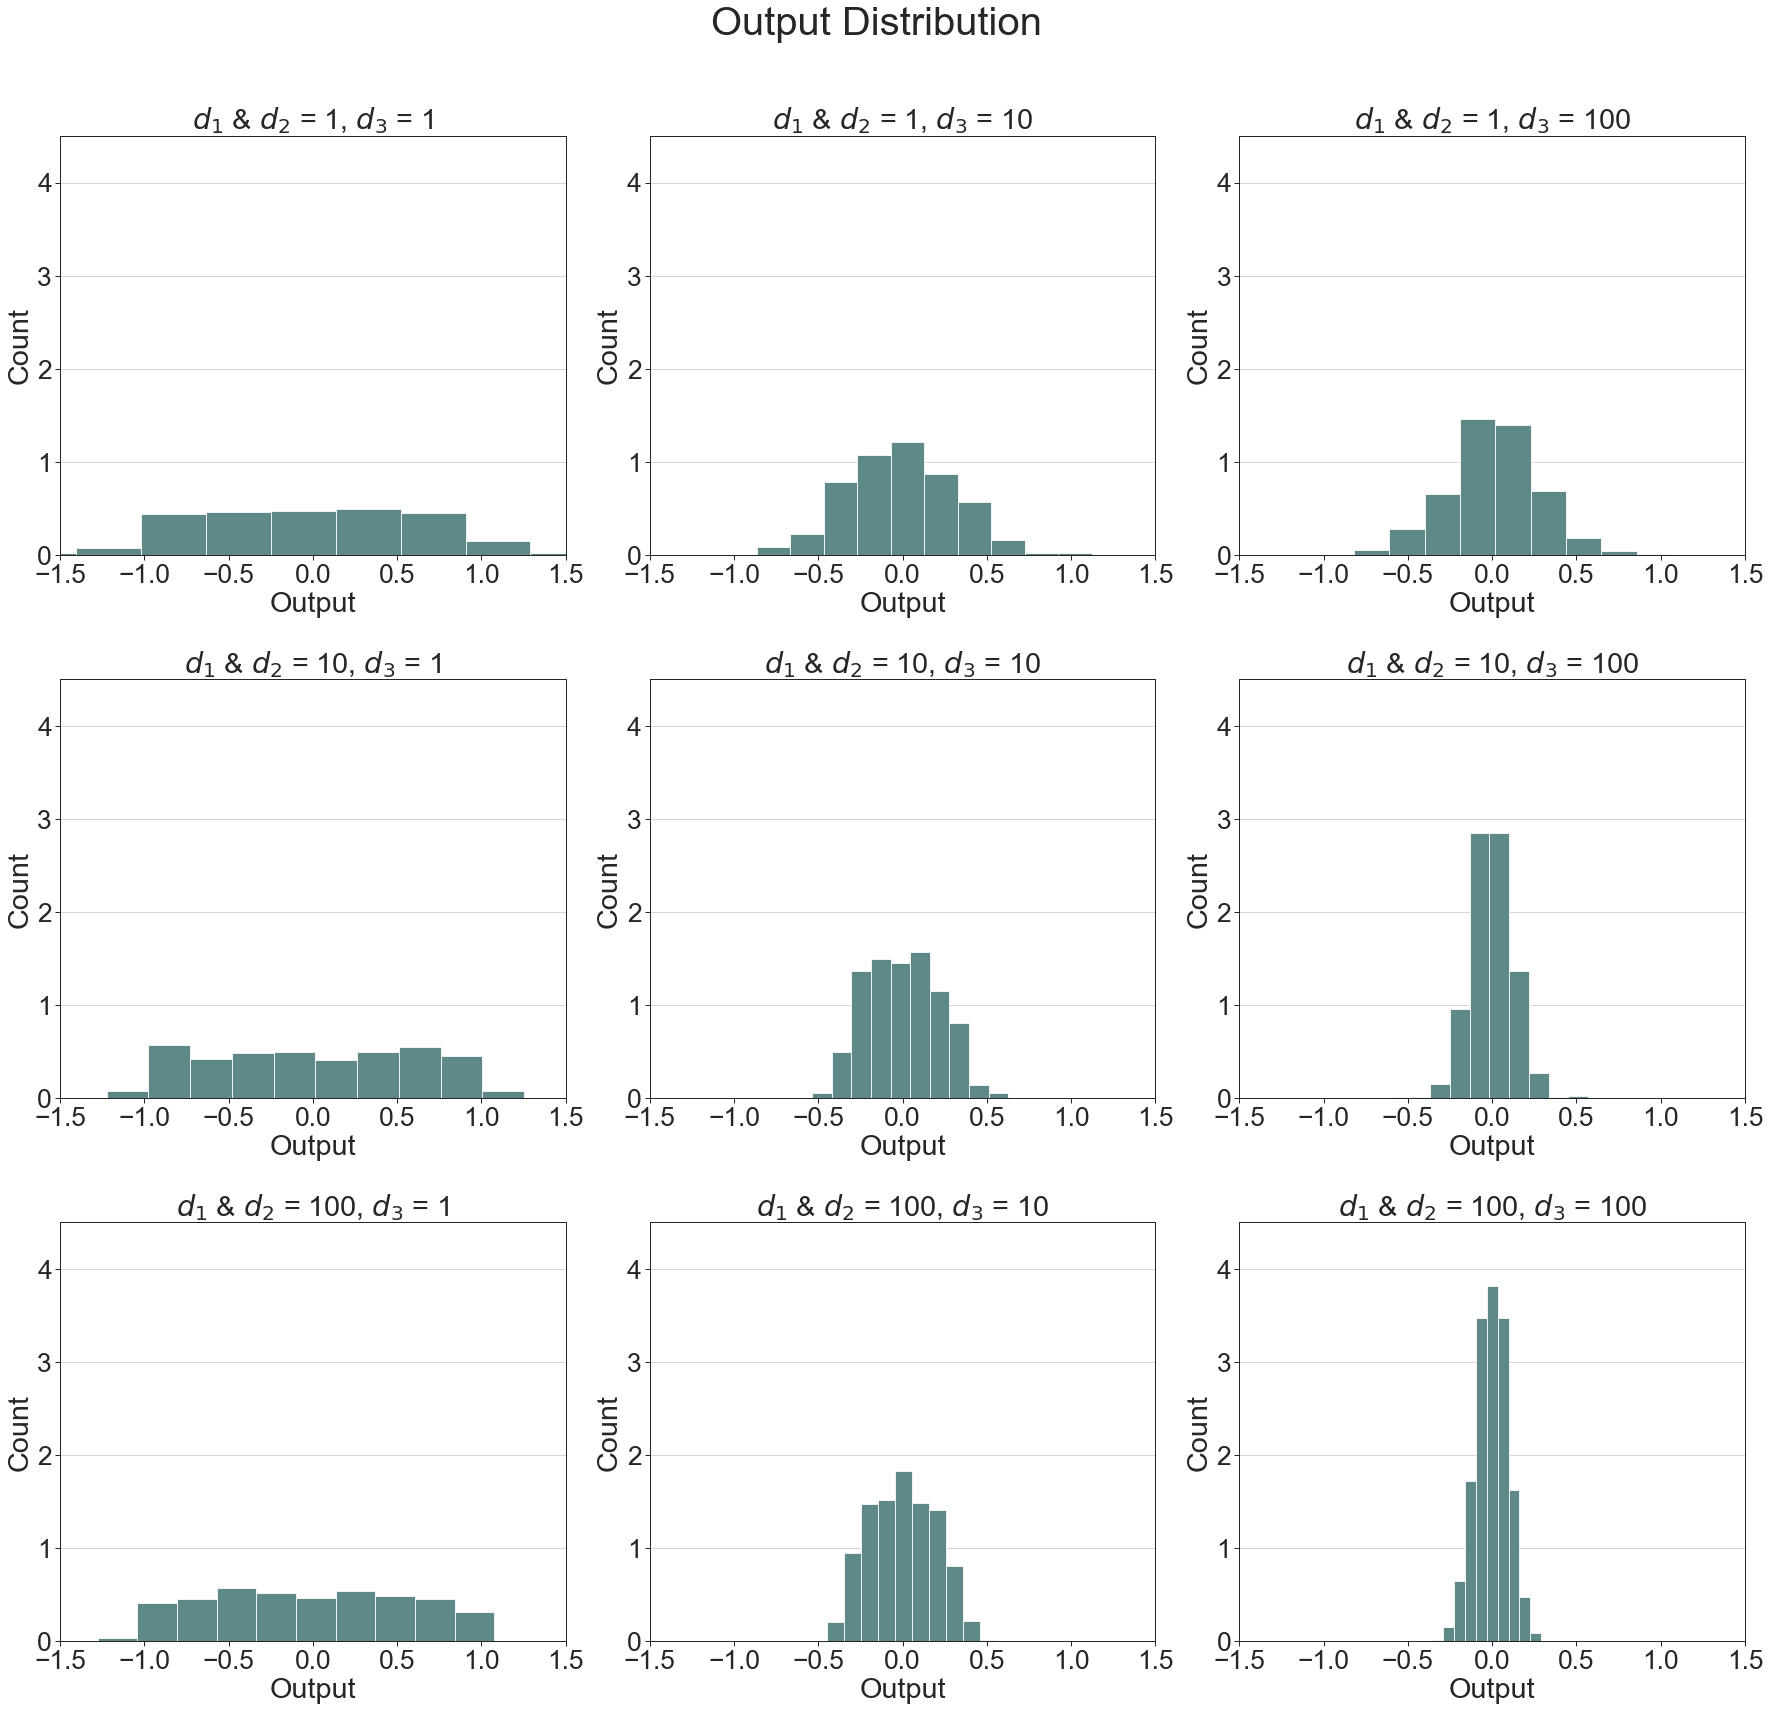

In [6]:
torch.manual_seed(0)
input_data = torch.normal(mean=0.0, std=1.0, size=(1, 1))

fig = plt.figure(figsize=(25, 25))
fig.suptitle("Output Distribution", y=0.96, size=40)

axs = []
for i in range(1, 10):
    ax = fig.add_subplot(3, 3, i)
    axs.append(ax)

cnt = 0
first_hid_dims = [1, 10, 100]
last_hid_dims = [1, 10, 100]
for first_hid_dim in tqdm(first_hid_dims):
    for last_hid_dim in last_hid_dims:
        ax = axs[cnt]
        plot_ax_nn_output_hist(ax, first_hid_dim, last_hid_dim, y_top=4.5, x_top=1.5)
        cnt += 1

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('figs/output_dist_1_10_100.pdf')
plt.show()

## Drawing of histograms for finer increments of layer width

  0%|          | 0/10 [00:00<?, ?it/s]

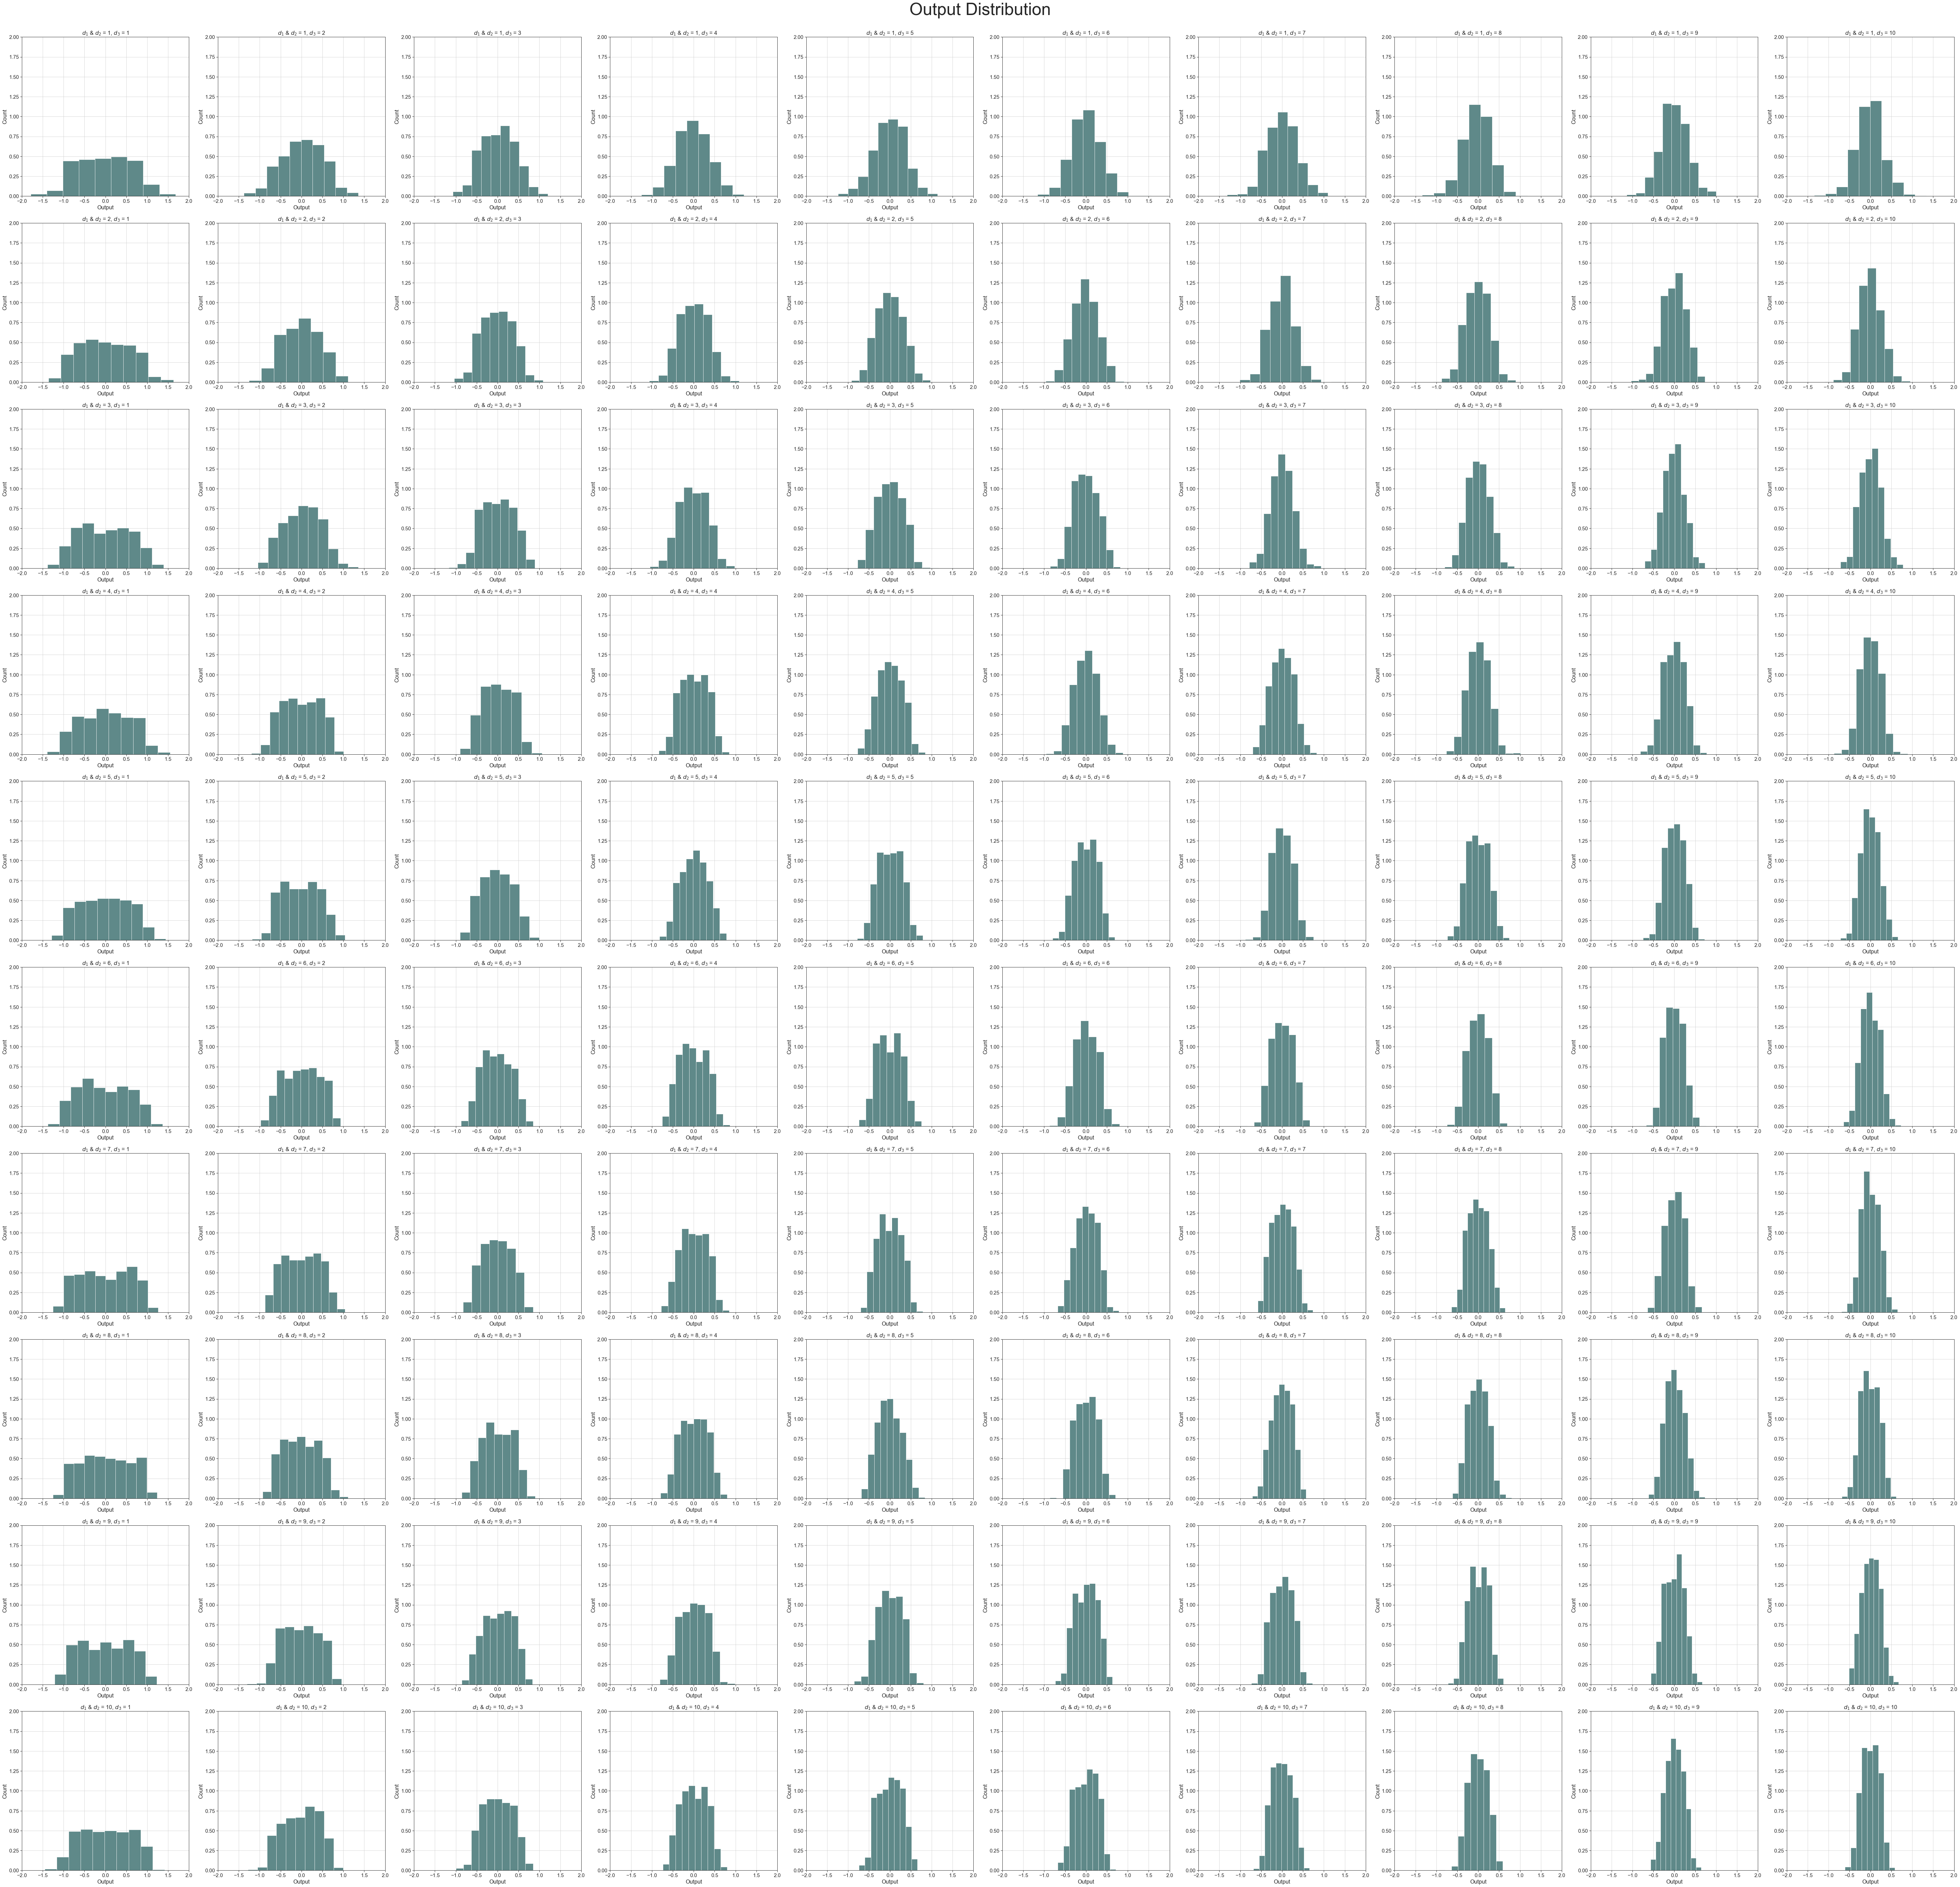

In [202]:
torch.manual_seed(0)
input_data = torch.normal(mean=0.0, std=1.0, size=(1, 1))

fig = plt.figure(figsize=(80, 80))
fig.suptitle("Output Distribution", size=50, y=0.96)

axs = []
for i in range(1, 101):
    ax = fig.add_subplot(10, 10, i)
    axs.append(ax)

cnt = 0
first_hid_dims = [i for i in range(1, 11)]
last_hid_dims = [i for i in range(1, 11)]
for first_hid_dim in tqdm(first_hid_dims):
    for last_hid_dim in last_hid_dims:
        ax = axs[cnt]
        plot_ax_nn_output_hist(ax, first_hid_dim, last_hid_dim, y_top=2)
        cnt += 1

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('figs/output_dist_10_10.pdf')
plt.show()

# Quantitative Evaluation

## Definition of functions to compute MMDs and drawing functions to compare MMDs at different layer widths

In [8]:
def calc_mmd(sigma, outputs):
    n = len(outputs)
    first_term = 1 / np.sqrt(2 * sigma ** 2 + 1)
    second_term = 0
    third_term = 0
    for output_1 in outputs:
        second_term += (- (2 / n) * (1 / np.sqrt(sigma ** 2 + 1)) * np.exp(- output_1 ** 2 / (2 * (sigma ** 2 + 1))))
        for output_2 in outputs:
            third_term += (1 / n ** 2) * np.exp(- (output_1 - output_2) ** 2 / 2)
    return first_term + second_term + third_term

def create_mmd_matrix(num_nn_models, first_hid_dims, last_hid_dims):
    torch.manual_seed(0)
    input_data = torch.normal(mean=0.0, std=1.0, size=(1, 1))
    mmd_matrix = []
    for first_hid_dim in tqdm(first_hid_dims):
        output_each_row = []
        for last_hid_dim in tqdm(last_hid_dims):
            output_list = []
            for _ in range(num_nn_models):
                model = NeuralNetwork(in_dim=1, hid_dim=first_hid_dim, last_hid_dim=last_hid_dim, out_dim=1)
                output = model(input_data).data.detach().numpy()[0][0]
                output_list.append(output)
            output_each_row.append(output_list)
        sigma = np.std(output_each_row[-1])
        mmds_each_row = []
        for column_id in range(len(last_hid_dims)):
            mmd = calc_mmd(sigma, output_each_row[column_id])
            mmds_each_row.append(mmd)
        mmd_matrix.append(mmds_each_row)
    return mmd_matrix

## MMDの計算

In [10]:
num_nn_models = 1000

first_hid_dims = [i for i in range(1, 11)]
last_hid_dims = [i for i in range(1, 11)]
mmd_matrix = create_mmd_matrix(num_nn_models, first_hid_dims, last_hid_dims)
df = pd.DataFrame(mmd_matrix)

## MMD plots for different layer widths

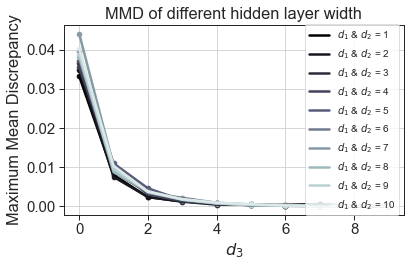

In [ ]:
sns.set_style("ticks")
sns.set_context(
    "paper",
    font_scale=1.7,
    rc={
        "lines.linewidth": 2.5
    }
)
matplotlib.rcParams['axes.grid'] = True
matplotlib.rcParams['axes.grid.axis'] = 'both'

for i, mmd_values in enumerate(mmd_matrix):
    plt.scatter(np.arange(len(mmd_matrix)), mmd_values, color=cm.bone(i / len(mmd_matrix)))
    plt.plot(mmd_values, label=r'$d_1$ & $d_2$ = 'f'{i + 1}', color=cm.bone(i / len(mmd_matrix)))
plt.title('MMD of different hidden layer width')
plt.ylabel('Maximum Mean Discrepancy')
plt.xlabel('$d_3$')
plt.legend(loc='right', fontsize=10)
plt.tight_layout()
plt.savefig('figs/mmd.pdf')
plt.show()